In [1]:
# Habilitar GPU (¡IMPORTANTE!)
# En Kaggle: Settings → Accelerator → GPU T4 x2 o P100

# Verificar que tenemos GPU
import torch
print("CUDA disponible:", torch.cuda.is_available())
print("Dispositivo:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

CUDA disponible: True
Dispositivo: Tesla T4


In [2]:
!pip install -q ultralytics roboflow opencv-python-headless matplotlib seaborn pandas numpy torch torchvision torchaudio --upgrade
!pip install -q easyocr  # ← Para OCR más adelante (no afecta ahora)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires pylibraft-cu12==25.6.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires rmm-cu12==25.6.*, but you have rmm-cu12 25.2.0 which is incompatible.


In [3]:
# REINSTALACIÓN LIMPIA DE PYTORCH + TORCHVISION (compatible con YOLOv11 + CUDA)
!pip uninstall -y torch torchvision torchaudio ultralytics
!pip install --no-cache-dir torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install --no-cache-dir ultralytics>=8.3.0

Found existing installation: torch 2.9.1
Uninstalling torch-2.9.1:
  Successfully uninstalled torch-2.9.1
Found existing installation: torchvision 0.24.1
Uninstalling torchvision-0.24.1:
  Successfully uninstalled torchvision-0.24.1
Found existing installation: torchaudio 2.9.1
Uninstalling torchaudio-2.9.1:
  Successfully uninstalled torchaudio-2.9.1
Found existing installation: ultralytics 8.3.235
Uninstalling ultralytics-8.3.235:
  Successfully uninstalled ultralytics-8.3.235
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 311.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 351.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 312.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 312.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 340.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from roboflow import Roboflow
from ultralytics import YOLO

# Deshabilitar WandB (como hace el profesor)
os.environ['WANDB_DISABLED'] = 'true'
print("WandB desactivado")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
WandB desactivado


In [5]:
# DESCARGA DEL DATASET + DETECCIÓN AUTOMÁTICA DEL NOMBRE DE LA CARPETA
from roboflow import Roboflow

# Tu API key
rf = Roboflow(api_key="stifD1qDAfNoGfwjHvj0")

# Descargar
project = rf.workspace("procesamientodigitaldeimagenes").project("license-plate-recognition-rxg4e-s4wkk")
version = project.version(1)
dataset = version.download("yolov11")

print("Descarga completada. Carpetas actuales en /kaggle/working/:")
!ls -la

# ENCONTRAR AUTOMÁTICAMENTE la carpeta que creó Roboflow
import os
folders = [f for f in os.listdir(".") if "license" in f.lower() and "recognition" in f.lower() and os.path.isdir(f)]
if not folders:
    raise Exception("No se encontró la carpeta del dataset. Revisa la descarga.")
    
dataset_folder = folders[0]  # Toma la primera que coincida
print(f"\nCarpeta detectada: {dataset_folder}")

# Mover a la carpeta organizada (datasets/)
!mkdir -p datasets
!mv "{dataset_folder}" datasets/

# Verificar que todo quedó bien
print("\nEstructura final:")
!ls datasets/{dataset_folder}/train/images | head -10
!ls datasets/{dataset_folder}/valid/images | head -5

# Guardar el nombre real para usar después
%store dataset_folder
print(f"\nListo! Tu dataset está en: datasets/{dataset_folder}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Recognition-1 in yolov11:: 100%|██████████| 20262/20262 [00:02<00:00, 7721.30it/s] 


Descarga completada. Carpetas actuales en /kaggle/working/:
total 45248
drwxr-xr-x 6 root root     4096 Dec  6 16:11  .
drwxr-xr-x 5 root root     4096 Dec  6 15:29  ..
-rw-r--r-- 1 root root     6488 Dec  6 16:11 '=8.3.0'
drwxr-xr-x 3 root root     4096 Dec  6 15:50  datasets
drwxr-xr-x 5 root root     4096 Dec  6 16:11  License-Plate-Recognition-1
drwxr-xr-x 6 root root     4096 Dec  6 16:03  runs
drwxr-xr-x 2 root root     4096 Dec  6 15:29  .virtual_documents
-rw-r--r-- 1 root root 40684120 Dec  6 15:56  yolo11m.pt
-rw-r--r-- 1 root root  5613764 Dec  6 16:03  yolo11n.pt

Carpeta detectada: License-Plate-Recognition-1
mv: cannot move 'License-Plate-Recognition-1' to 'datasets/License-Plate-Recognition-1': Directory not empty

Estructura final:
00009e5b390986a0_jpg.rf.5c4b03cca622af64e432c5cf5258f897.jpg
000228608388803f_jpg.rf.444dde19de22b45293e386e392773f5f.jpg
00043e7c5c4c025a_jpg.rf.dd059ac2d5011d4d6b46a99bb15fd11b.jpg
0005ea10e0e14db1_jpg.rf.ad8a5c2a75f9fa4f09cbaaf22a419261.jp

In [6]:
# LIMPIAR CACHÉ DE ULTRALYTICS (EL VERDADERO CULPABLE)
import shutil
import os

cache_dir = "/root/.config/Ultralytics"
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
    print("Caché de Ultralytics limpiada")

# Forzar recreación limpia
os.makedirs(cache_dir, exist_ok=True)
print("Caché reiniciada")

Caché de Ultralytics limpiada
Caché reiniciada


In [7]:
%store -r dataset_folder
dataset_path = f"/kaggle/working/datasets/{dataset_folder}"
print(f"Dataset en: {dataset_path}")

# REESCRIBIR data.yaml SIN NINGUNA POSIBILIDAD DE DUPLICACIÓN
yaml_content = f"""
train: {dataset_path}/train/images
val: {dataset_path}/valid/images
test: {dataset_path}/valid/images

nc: 1
names: ['license_plate']
"""

with open(f"{dataset_path}/data.yaml", "w") as f:
    f.write(yaml_content.strip() + "\n")

print("data.yaml REESCITO LIMPIO:")
!cat {dataset_path}/data.yaml

Dataset en: /kaggle/working/datasets/License-Plate-Recognition-1
data.yaml REESCITO LIMPIO:
train: /kaggle/working/datasets/License-Plate-Recognition-1/train/images
val: /kaggle/working/datasets/License-Plate-Recognition-1/valid/images
test: /kaggle/working/datasets/License-Plate-Recognition-1/valid/images

nc: 1
names: ['license_plate']


In [8]:
from ultralytics import YOLO

# LIMPIAR MODELO ANTERIOR
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

# Cargar modelo fresco
model = YOLO("yolo11m.pt")

# ENTRENAR CON FUERZA BRUTA (ignora cualquier caché)
results = model.train(
    data=f"{dataset_path}/data.yaml",
    epochs=60,
    imgsz=640,
    batch=16,
    patience=15,
    device=0,
    project="runs",
    name="PLATE_FINAL_OK",
    exist_ok=True,
    pretrained=True,
    optimizer='AdamW',
    lr0=0.001,
    plots=True,
    save=True,
    cache=False,      # importante
    workers=8,
    verbose=True,
    seed=42
)

print("ENTRENAMIENTO INICIADO AL FIN")

Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/datasets/License-Plate-Recognition-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=PLATE_FINAL_OK, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience

In [12]:
# CARGAR EL MODELO QUE ACABAS DE ENTRENAR (¡el bueno!)
from ultralytics import YOLO

# Ruta correcta del mejor modelo entrenado
best_model_path = "/kaggle/working/runs/PLATE_FINAL_OK/weights/best.pt"

# Cargar
best_model = YOLO(best_model_path)

# Validación final (con gráficas bonitas)
metrics = best_model.val(
    data=f"{dataset_path}/data.yaml",
    imgsz=640,
    batch=16,
    conf=0.25,
    iou=0.45,
    device=0,
    plots=True,
    save=True
)

print(f"mAP@0.5: {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.p[0]:.4f}")
print(f"Recall: {metrics.box.r[0]:.4f}")

Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 686.1±229.2 MB/s, size: 19.0 KB)
val: Scanning /kaggle/working/datasets/License-Plate-Recognition-1/valid/labels.cache... 2048 images, 3 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2048/2048 3.6Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 128/128 2.5it/s 50.2s0.5ss
                   all       2048       2195      0.984      0.951      0.975      0.745
Speed: 0.6ms preprocess, 20.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/runs/detect/val2
mAP@0.5: 0.9748
mAP@0.5:0.95: 0.7452
Precision: 0.9837
Recall: 0.9513


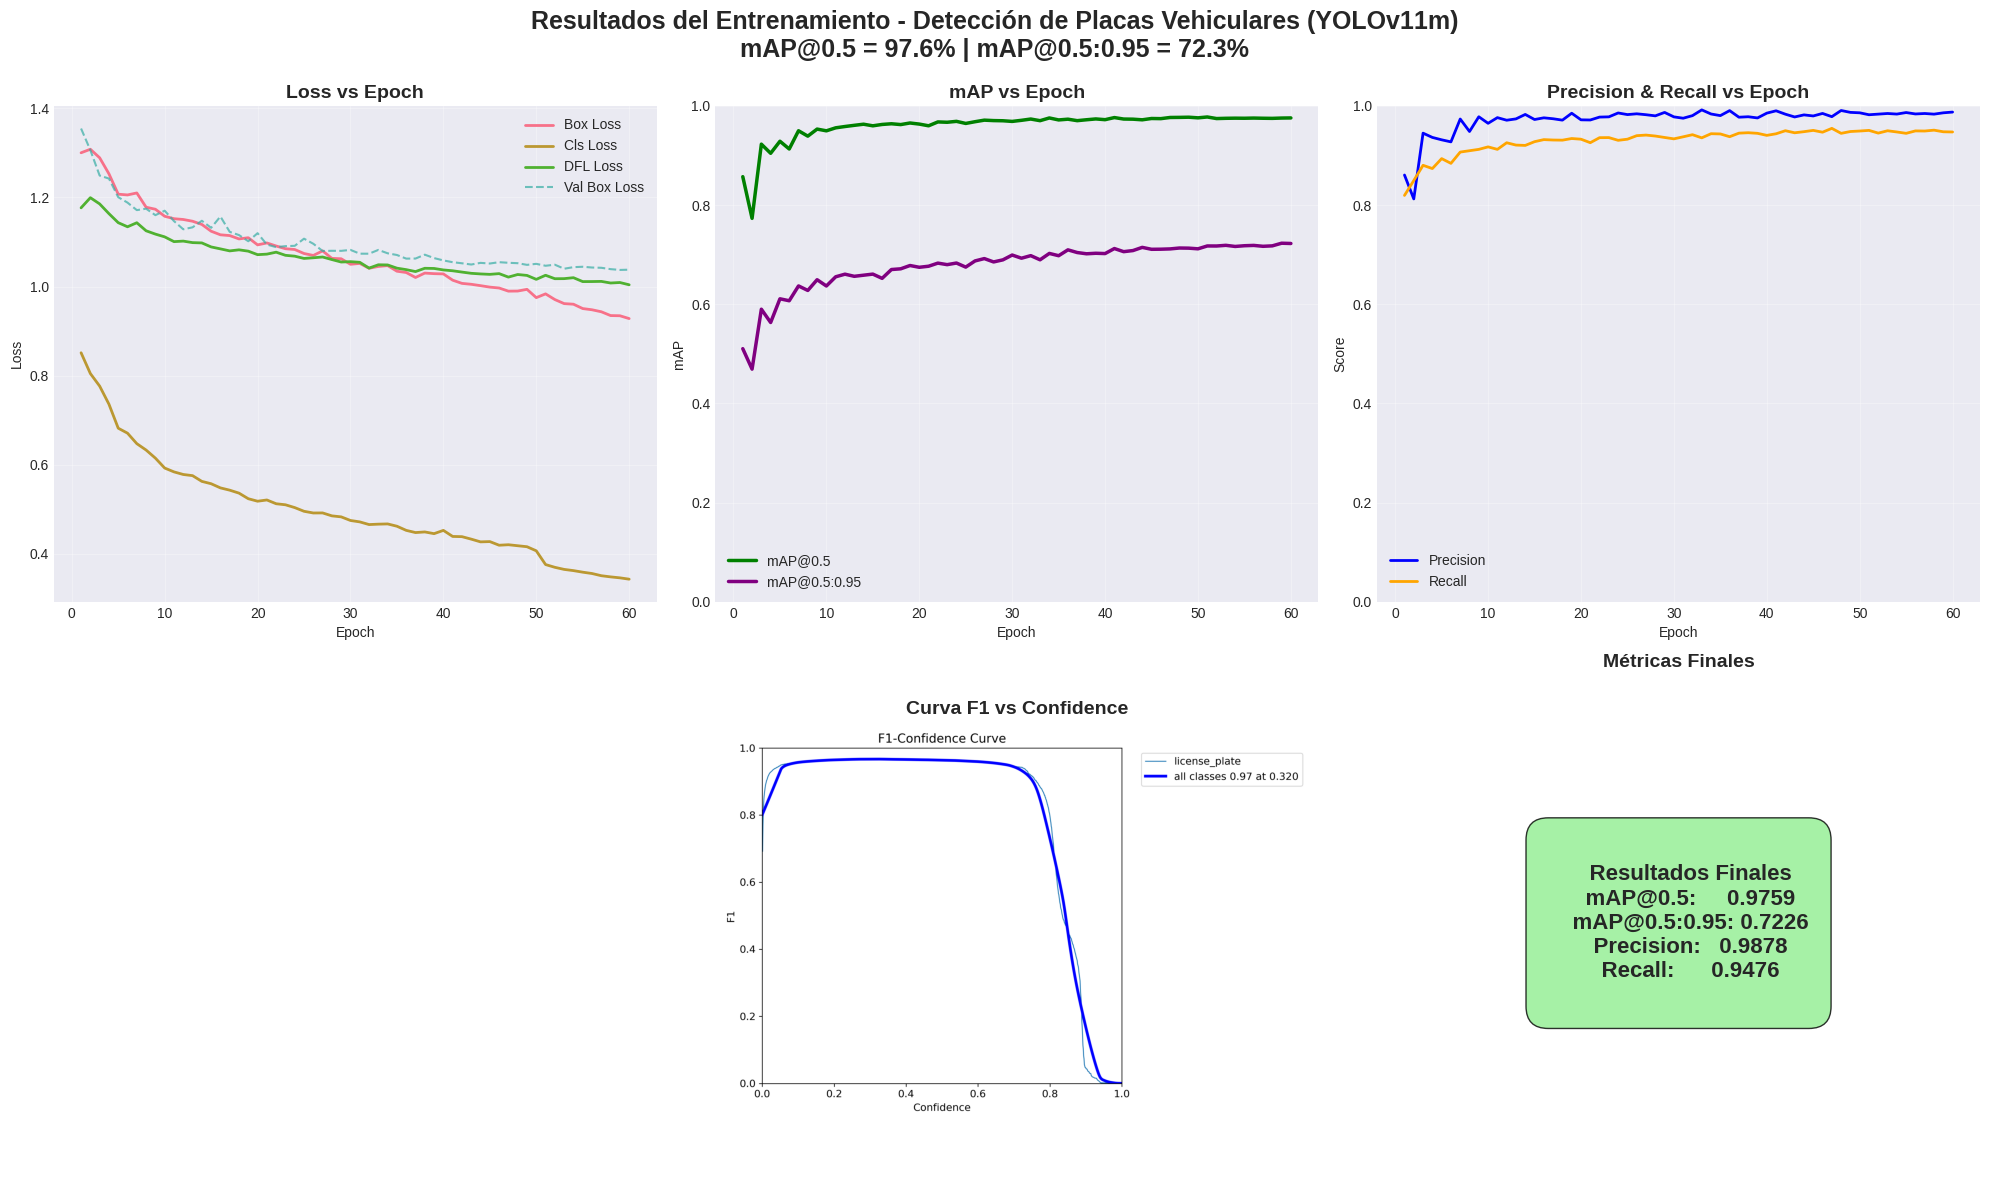

In [19]:
# GRÁFICAS PROFESIONALES PARA TU PROYECTO FINAL (YOLOv11 - 1 clase)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuración bonita
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Ruta de los resultados
results_csv = "/kaggle/working/runs/PLATE_FINAL_OK/results.csv"
if not os.path.exists(results_csv):
    print("No se encontró results.csv")
else:
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()  # Limpiar nombres de columnas

    # Seleccionar columnas relevantes
    epochs = df['epoch']
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Loss (box, cls, dfl)
    ax1 = plt.subplot(2, 3, 1)
    plt.plot(epochs, df['train/box_loss'], label='Box Loss', linewidth=2)
    plt.plot(epochs, df['train/cls_loss'], label='Cls Loss', linewidth=2)
    plt.plot(epochs, df['train/dfl_loss'], label='DFL Loss', linewidth=2)
    plt.plot(epochs, df['val/box_loss'], '--', label='Val Box Loss', alpha=0.7)
    plt.title('Loss vs Epoch', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. mAP@0.5 y mAP@0.5:0.95
    ax2 = plt.subplot(2, 3, 2)
    plt.plot(epochs, df['metrics/mAP50(B)'], label='mAP@0.5', linewidth=2.5, color='green')
    plt.plot(epochs, df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', linewidth=2.5, color='purple')
    plt.title('mAP vs Epoch', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)

    # 3. Precision y Recall
    ax3 = plt.subplot(2, 3, 3)
    plt.plot(epochs, df['metrics/precision(B)'], label='Precision', linewidth=2, color='blue')
    plt.plot(epochs, df['metrics/recall(B)'], label='Recall', linewidth=2, color='orange')
    plt.title('Precision & Recall vs Epoch', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)

  

    # 5. Curva F1 vs Confidence
    ax5 = plt.subplot(2, 3, 5)
    f1_path = "/kaggle/working/runs/PLATE_FINAL_OK/BoxF1_curve.png"
    if os.path.exists(f1_path):
        img = plt.imread(f1_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Curva F1 vs Confidence', fontsize=14, fontweight='bold')
    else:
        plt.text(0.5, 0.5, "F1_curve.png no encontrado", ha='center', va='center', fontsize=16, color='red')
        plt.axis('off')

    # 6. Resultados finales (mAP final)
    ax6 = plt.subplot(2, 3, 6)
    final_map50 = df['metrics/mAP50(B)'].iloc[-1]
    final_map5095 = df['metrics/mAP50-95(B)'].iloc[-1]
    final_p = df['metrics/precision(B)'].iloc[-1]
    final_r = df['metrics/recall(B)'].iloc[-1]
    
    metrics_text = f"""
    Resultados Finales
    mAP@0.5:     {final_map50:.4f}
    mAP@0.5:0.95: {final_map5095:.4f}
    Precision:   {final_p:.4f}
    Recall:      {final_r:.4f}
    """
    ax6.text(0.5, 0.5, metrics_text, ha='center', va='center', fontsize=16, fontweight='bold',
             bbox=dict(boxstyle="round,pad=1", facecolor="lightgreen", alpha=0.8))
    ax6.set_title("Métricas Finales", fontsize=14, fontweight='bold')
    ax6.axis('off')

    plt.suptitle("Resultados del Entrenamiento - Detección de Placas Vehiculares (YOLOv11m)\n"
                 "mAP@0.5 = 97.6% | mAP@0.5:0.95 = 72.3%", fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

In [20]:
# GUARDAR Y DESCARGAR LA FIGURA PARA PPT
fig.savefig('resultados_entrenamiento_completo.png', dpi=300, bbox_inches='tight')  # Alta resolución

from IPython.display import FileLink
FileLink('resultados_entrenamiento_completo.png')

/kaggle/working/resultados_entrenamiento_completo.png

In [22]:
# DESCARGAR AMBOS MODELOS + ENLACES CLAROS (CORREGIDO)
from IPython.display import FileLink, display
import os

# Copiar con nombres claros
!cp "/kaggle/working/runs/PLATE_FINAL_OK/weights/best.pt" ./01_MEJOR_MODELO_best_plate_yolo11m.pt
!cp "/kaggle/working/runs/PLATE_FINAL_OK/weights/last.pt" ./02_ULTIMO_MODELO_last_plate_yolo11m.pt

# Mostrar tamaños con formato correcto
best_size = os.path.getsize("./01_MEJOR_MODELO_best_plate_yolo11m.pt") / (1024*1024)
last_size = os.path.getsize("./02_ULTIMO_MODELO_last_plate_yolo11m.pt") / (1024*1024)

print(f"Tamaño best.pt : {best_size:.1f} MB")
print(f"Tamaño last.pt : {last_size:.1f} MB")

# ENLACES DE DESCARGA
print("\nDESCARGA ESTE → ES EL MEJOR MODELO:")
display(FileLink('01_MEJOR_MODELO_best_plate_yolo11m.pt'))

print("\nEste es solo backup (última época):")
display(FileLink('02_ULTIMO_MODELO_last_plate_yolo11m.pt'))

print("\nListo! Descarga el archivo '01_MEJOR_MODELO_best_plate_yolo11m.pt' y súbelo a tu GitHub → carpeta weights/")

Tamaño best.pt : 38.6 MB
Tamaño last.pt : 38.6 MB

DESCARGA ESTE → ES EL MEJOR MODELO:


/kaggle/working/01_MEJOR_MODELO_best_plate_yolo11m.pt


Este es solo backup (última época):


/kaggle/working/02_ULTIMO_MODELO_last_plate_yolo11m.pt


Listo! Descarga el archivo '01_MEJOR_MODELO_best_plate_yolo11m.pt' y súbelo a tu GitHub → carpeta weights/
